In [1]:
import matplotlib
#matplotlib.use('TKagg')
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pandas as pd
import json 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def json_load(filename):
   with open(filename) as f_in:
       return(json.load(f_in)["mean"]["point_estimate"])

In [3]:
def load_files(dirname):
    folders = os.listdir(dirname)
    #print(folders)
    csv_files = list(map(lambda name: os.path.join(os.path.join(dirname, name),'new/raw.csv'), folders))

    #print(csv_files)


    df_from_each_file = (pd.read_csv(f, sep=',') for f in csv_files)
    #print(list(df_from_each_file))
    df_from_each_file = (f.head(1) for f in df_from_each_file)
    #print(list(df_from_each_file))
    return df_from_each_file


In [4]:
def size_calculation(value):
    element_size = int(value.split("-")[0])
    vector_size = int(value.split("-")[1])
    matrixs_size =  (((32 * element_size * element_size) * 3) * 2) * vector_size
    #normal_elements_size = ((6 * 32 * 1000) + (2 * 32 * 1000) + (6 * 32)) * vector_size
   
    return matrixs_size /8

In [5]:
def merge_csvs(directory):
    dirname = directory

    df_from_each_file = list(load_files(dirname)) 
    df_merged   = pd.concat(df_from_each_file, ignore_index=True)
        

    del df_merged["group"]
    del df_merged["throughput_type"]
    del df_merged["sample_measured_value"]
    del df_merged["unit"]
    del df_merged["iteration_count"]
    folders = df_merged['value']

    df_merged["time"] = list(map(lambda name: json_load(os.path.join(os.path.join(dirname, name),'new/estimates.json')), folders))

    time = df_merged['time']
    value = df_merged['value']
    del df_merged["throughput_num"]
    df_merged['element_size'] = list(map(lambda size:  int(size.split("-")[0]),value))
    df_merged['vector_size'] = list(map(lambda size: int(size.split("-")[1]),value))
    df_merged["throughput_num"] = list(map(lambda v: size_calculation(v), value))
    df_merged['time'] = list(map(lambda value: value/1000000, time))
    df_merged["throughput"] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["throughput_num"], df_merged['time']))))
    df_merged['size'] = list(map(lambda value: value/(1024**2), df_merged["throughput_num"]))
    df_merged['total_element_size'] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["size"], df_merged['vector_size']))))
    entry = df_merged.head().iloc[0]
    
    if entry['function'] == 'tokio' or entry['function'] == 'tokio_seq' :
        values = df_merged[df_merged.value.str.contains(r".*-36$")]
        values['value'] = list(map(lambda v: v.split("-")[0]+'-'+ v.split("-")[1] ,values['value']))
        return values
    
    
    return df_merged



def get_csv(directory):
    dirname = directory
    df_merged = (pd.read_csv(dirname, sep=','))
    print(df_merged)
    time = df_merged['time']
    value = df_merged['value']
    df_merged['element_size'] = list(map(lambda size:  int(size.split("-")[0]),value))
    df_merged['vector_size'] = list(map(lambda size: int(size.split("-")[1]),value))
    df_merged["throughput_num"] = list(map(lambda v: size_calculation(v), value))
    df_merged["throughput"] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["throughput_num"], df_merged['time']))))
    df_merged['size'] = list(map(lambda value: value/(1024**2), df_merged["throughput_num"]))
    df_merged['total_element_size'] = list(map(lambda ab: float(ab[0]/ab[1]) ,list(zip(df_merged["size"], df_merged['vector_size']))))

    df_merged['function'] = "taskflow"
    
    
    
    return df_merged



In [6]:
directories = [
#"./benchmarks_schedulers/sequential"
#"./benchmarks_schedulers/sequential_par_iter"
"./benchmarks_schedulers/sequential_for_loop"
,"./benchmarks_schedulers/parallel_speculative_iter"
#,"./benchmarks_schedulers/parallel_speculative_par_iter"
,"./benchmarks_schedulers/speculative"
#,"./benchmarks_schedulers/async"
#,"./benchmarks_schedulers/tokio"
#,"./benchmarks_schedulers/tokio_seq"
]

#csv =  get_csv("./taskflow/bench.csv")
csvs = list(map(lambda dir:merge_csvs(dir), directories))
#csvs.append(csv)
#files = [csv[0], csvs]
#csvs = pd.concat(files , ignore_index=True)

In [7]:
#common_values = list(set(df1.Col1) & set(df2.Col1) & set(df3.Col1))
from functools import reduce

values = list(reduce(lambda acc,v: acc & set(v['value']) ,csvs,set(csvs[0]['value'])))

print(list(values))
#l = csvs[0].loc[csvs[0]['value'].isin(values)]
#print(l)

l = list(map(lambda value: value.loc[value['value'].isin(values)]  ,csvs))

l = list(map(lambda value: value.sort_values(by=["size"], ascending=False)  ,l))
time_ord = list(map(lambda value: value.sort_values(by=["time"], ascending=False)  ,l))



['32-800', '64-9600', '32-4800', '64-96', '512-96', '64-240', '32-9600', '256-12000', '64-1200', '64-360', '512-24', '64-800', '512-12', '128-12', '256-2400', '128-24', '32-48', '64-4800', '128-800', '128-2400', '32-2400', '32-240', '32-1200', '128-9600', '128-360', '512-120', '128-96', '256-360', '32-360', '32-12', '128-240', '64-48', '512-600', '128-1200', '32-600', '256-240', '256-96', '32-24', '32-96', '512-360', '128-4800', '256-9600', '512-240', '256-120', '256-1200', '64-24', '256-12', '128-600', '256-24', '64-120', '512-48', '256-600', '256-4800', '64-12000', '256-800', '128-48', '512-800', '128-120', '64-600', '32-12000', '64-12', '32-120', '64-2400', '128-12000', '256-48']


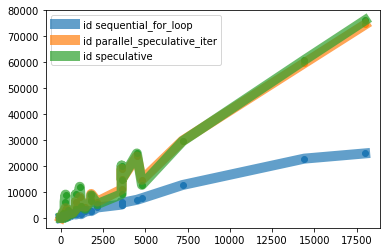

In [8]:
for v  in l :
    plt.scatter(v['size'],v['time'])

    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["axes.labelsize"] = 2
#plt.xscale('log',base=2) 
#plt.yscale('log',base=2) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    


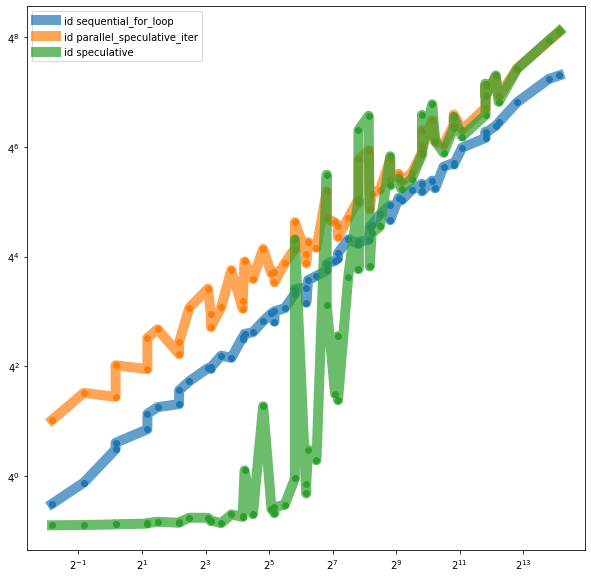

In [9]:
for v  in l :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.rcParams["axes.labelsize"] = 5

plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

In [10]:
coisa = list(map(lambda value: value[value.function.str.contains(r"^speculative")],l))
coisa = list(map(lambda value: value.sort_values(by=["time"], ascending=False),coisa))
pd.set_option('display.max_columns', None)
print(coisa)

[Empty DataFrame
Columns: [function, value, time, element_size, vector_size, throughput_num, throughput, size, total_element_size]
Index: [], Empty DataFrame
Columns: [function, value, time, element_size, vector_size, throughput_num, throughput, size, total_element_size]
Index: [],        function      value          time  element_size  vector_size  \
54  speculative  256-12000  76229.687029           256        12000   
22  speculative   256-9600  60862.603143           256         9600   
1   speculative   256-4800  29584.285253           256         4800   
37  speculative  128-12000  24851.416092           128        12000   
25  speculative   128-9600  20181.327487           128         9600   
..          ...        ...           ...           ...          ...   
18  speculative      64-24      0.300922            64           24   
11  speculative      32-48      0.296322            32           48   
41  speculative      64-12      0.295077            64           12   
52  spe

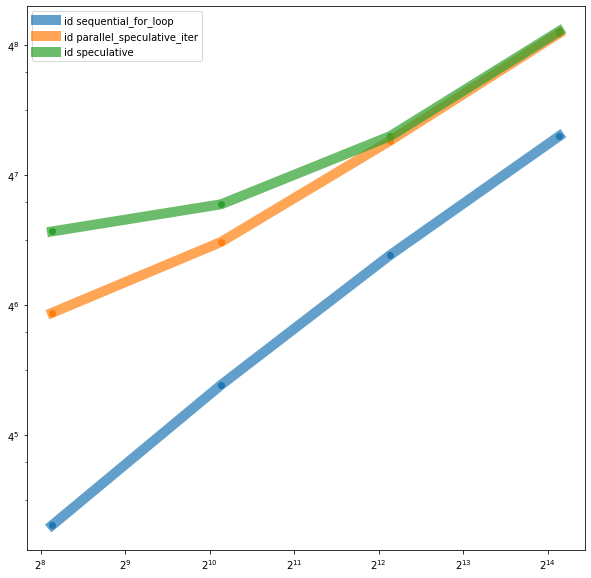

In [11]:
# 256-12000
a = list(map(lambda value: value[value.value.str.contains(r"^.*-12000")],l))

for v  in a :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

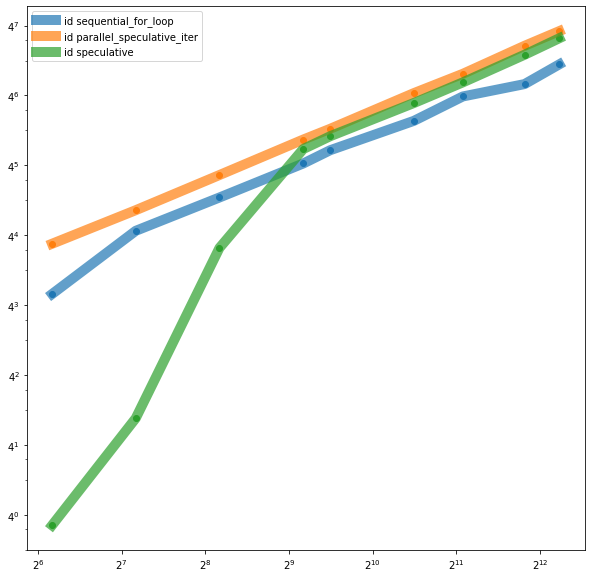

In [12]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^512-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'])
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

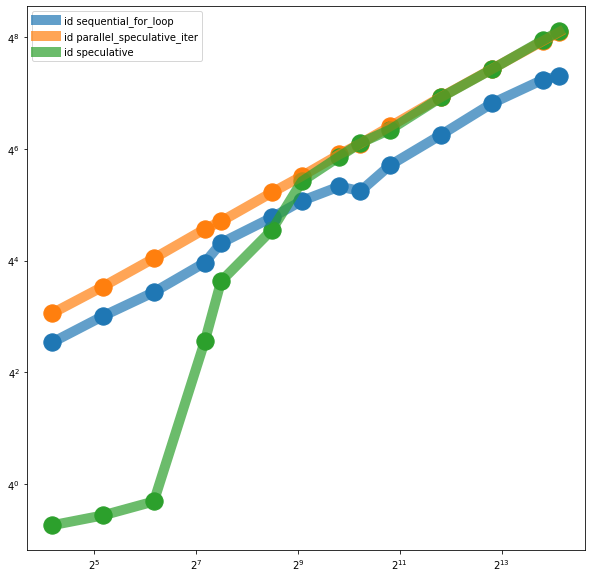

In [13]:
# 512-800

b = list(map(lambda value: value[value.value.str.contains(r"^256-.*")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

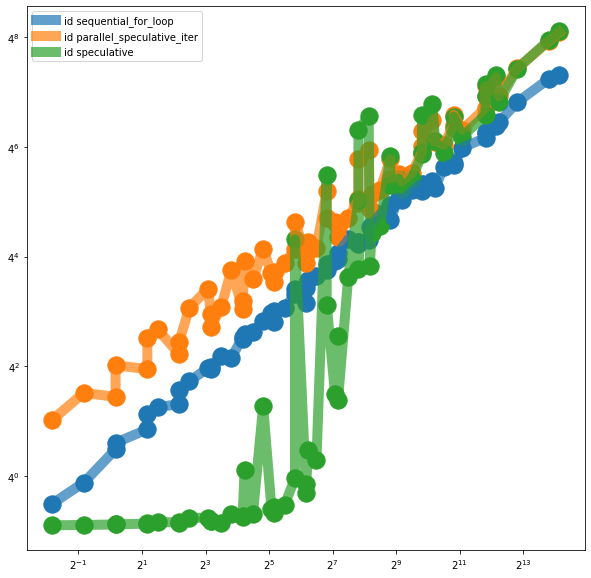

In [14]:
for v  in l :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["axes.labelsize"] = 25
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

[               function     value        time  element_size  vector_size  \
56  sequential_for_loop  32-12000  390.364637            32        12000   
3   sequential_for_loop   32-9600  370.781896            32         9600   
11  sequential_for_loop   32-4800  180.535371            32         4800   
42  sequential_for_loop   32-2400  113.199180            32         2400   
63  sequential_for_loop   32-1200   50.154643            32         1200   
65  sequential_for_loop    32-800   36.288059            32          800   
0   sequential_for_loop    32-600   19.850661            32          600   
34  sequential_for_loop    32-360   15.300285            32          360   
60  sequential_for_loop    32-240   11.008249            32          240   
35  sequential_for_loop    32-120    5.708970            32          120   
62  sequential_for_loop     32-96    4.812353            32           96   
10  sequential_for_loop     32-48    2.322067            32           48   
57  sequent

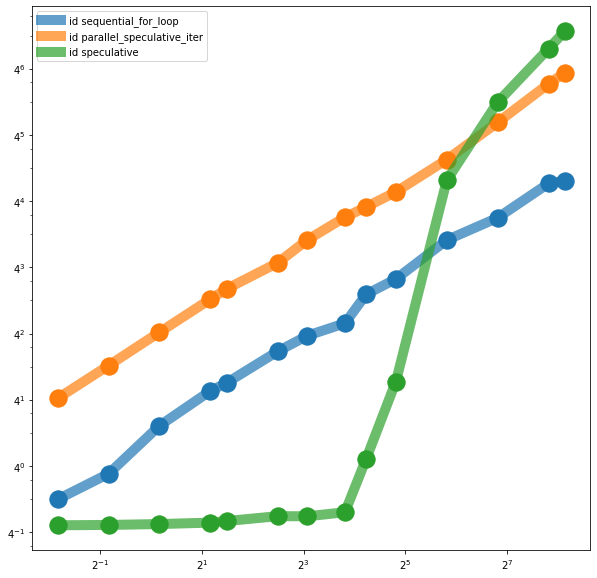

In [15]:
b = list(map(lambda value: value[value.value.str.contains(r"^32-.*")] ,l))

print(b)
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

[               function    value         time  element_size  vector_size  \
69  sequential_for_loop  512-800  7599.964127           512          800   
39  sequential_for_loop  512-600  5135.901052           512          600   
71  sequential_for_loop  512-360  4018.259112           512          360   
72  sequential_for_loop  512-240  2477.176701           512          240   
12  sequential_for_loop  512-120  1383.269995           512          120   
4   sequential_for_loop   512-96  1063.023678           512           96   
38  sequential_for_loop   512-48   541.829099           512           48   
32  sequential_for_loop   512-24   279.769183           512           24   
49  sequential_for_loop   512-12    79.843529           512           12   

    throughput_num     throughput    size  total_element_size  
69    5.033165e+09  662261.652313  4800.0                 6.0  
39    3.774874e+09  734997.337703  3600.0                 6.0  
71    2.264924e+09  563658.065990  2160.0     

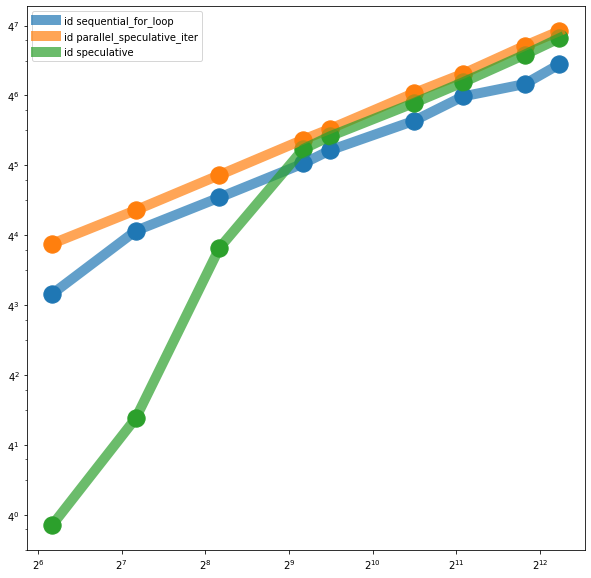

In [36]:
b = list(map(lambda value: value[value.value.str.contains(r"^512-.*")] ,l))
print(b)
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

[               function      value          time  element_size  vector_size  \
59  sequential_for_loop  256-12000  24883.128325           256        12000   
21  sequential_for_loop   256-9600  22863.021905           256         9600   
1   sequential_for_loop   256-4800  12692.515408           256         4800   
47  sequential_for_loop   256-2400   5808.508628           256         2400   
16  sequential_for_loop   256-1200   2736.331681           256         1200   
52  sequential_for_loop    256-800   1433.698101           256          800   
70  sequential_for_loop    256-600   1609.291183           256          600   
53  sequential_for_loop    256-360   1126.926000           256          360   
8   sequential_for_loop    256-240    745.628078           256          240   
13  sequential_for_loop    256-120    396.104603           256          120   
68  sequential_for_loop     256-96    242.744088           256           96   
25  sequential_for_loop     256-48    116.739233   

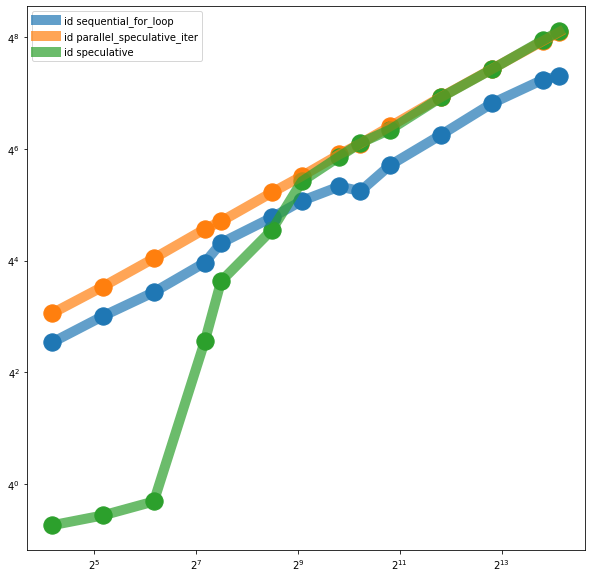

In [30]:
b = list(map(lambda value: value[value.value.str.contains(r"^256-.*")] ,l))

print(b)
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

[               function     value         time  element_size  vector_size  \
16  sequential_for_loop  256-1200  2736.331681           256         1200   
29  sequential_for_loop  128-1200   642.660548           128         1200   
22  sequential_for_loop   64-1200   211.873942            64         1200   
63  sequential_for_loop   32-1200    50.154643            32         1200   

    throughput_num     throughput      size  total_element_size  
16    1.887437e+09  689769.011860  1800.000            1.500000  
29    4.718592e+08  734227.737741   450.000            0.375000  
22    1.179648e+08  556768.798455   112.500            0.093750  
63    2.949120e+07  588005.378872    28.125            0.023438  ,                      function     value         time  element_size  \
16  parallel_speculative_iter  256-1200  7160.899108           256   
29  parallel_speculative_iter  128-1200  1832.610529           128   
22  parallel_speculative_iter   64-1200   670.504552            64   
63

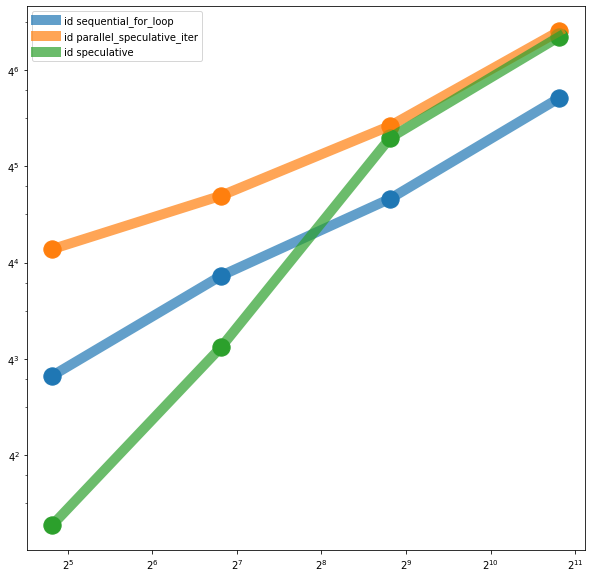

In [32]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']


b = list(map(lambda value: value[value.value.str.contains(r",*-1200$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
print(b)
  
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()
    

[               function    value         time  element_size  vector_size  \
12  sequential_for_loop  512-120  1383.269995           512          120   
13  sequential_for_loop  256-120   396.104603           256          120   
7   sequential_for_loop  128-120    69.448524           128          120   
51  sequential_for_loop   64-120    20.967726            64          120   
35  sequential_for_loop   32-120     5.708970            32          120   

    throughput_num     throughput      size  total_element_size  
12     754974720.0  545789.847655  720.0000            6.000000  
13     188743680.0  476499.587059  180.0000            1.500000  
7       47185920.0  679437.333135   45.0000            0.375000  
51      11796480.0  562601.787970   11.2500            0.093750  
35       2949120.0  516576.552192    2.8125            0.023438  ,                      function    value         time  element_size  \
12  parallel_speculative_iter  512-120  2115.263795           512   
13  par

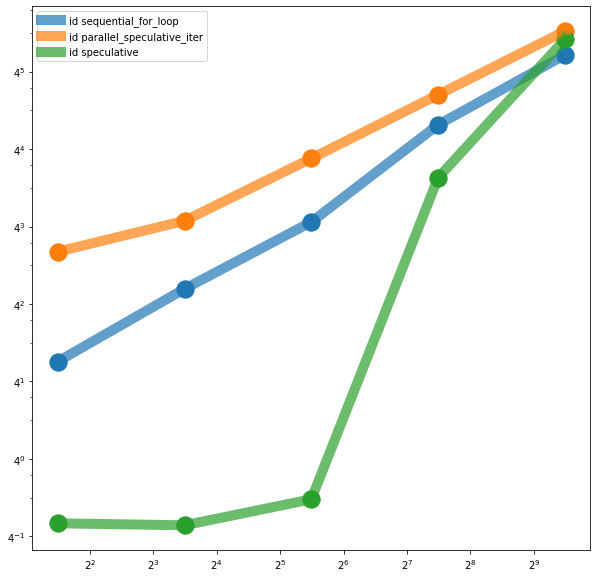

In [33]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-120$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
print(b)
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

[               function   value       time  element_size  vector_size  \
49  sequential_for_loop  512-12  79.843529           512           12   
14  sequential_for_loop  256-12  33.430969           256           12   
33  sequential_for_loop  128-12   6.173741           128           12   
45  sequential_for_loop   64-12   1.967828            64           12   
55  sequential_for_loop   32-12   0.497467            32           12   

    throughput_num     throughput      size  total_element_size  
49      75497472.0  945567.830039  72.00000            6.000000  
14      18874368.0  564577.355781  18.00000            1.500000  
33       4718592.0  764300.291157   4.50000            0.375000  
45       1179648.0  599467.162742   1.12500            0.093750  
55        294912.0  592827.220081   0.28125            0.023438  ,                      function   value        time  element_size  vector_size  \
49  parallel_speculative_iter  512-12  216.332012           512           12   
14 

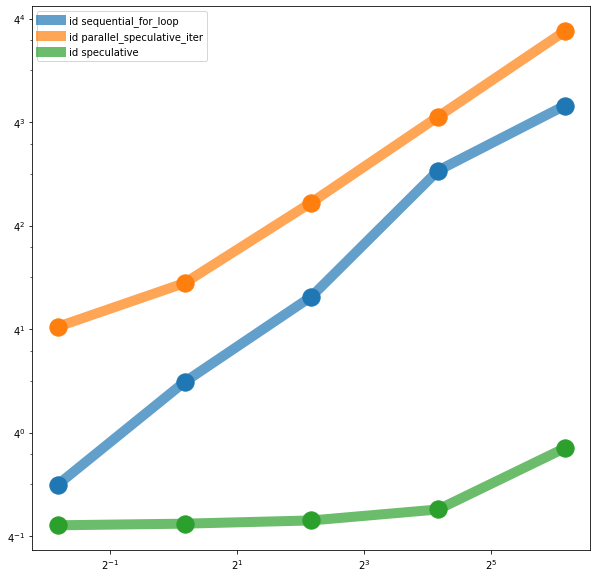

In [34]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-12$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
print(b)
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

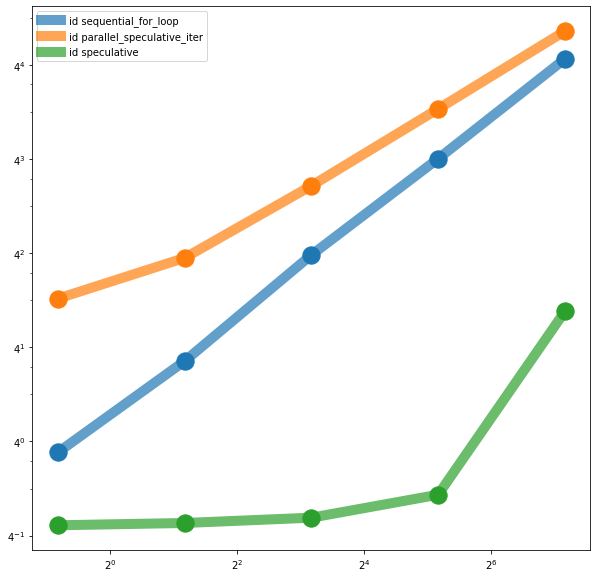

In [21]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-24$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

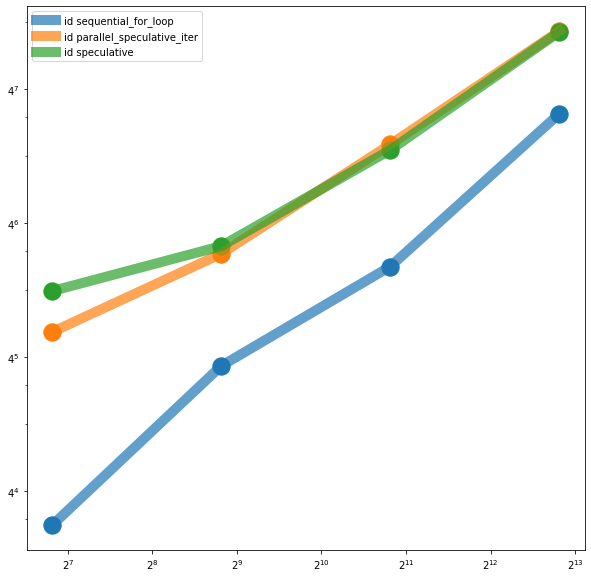

In [22]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-4800$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

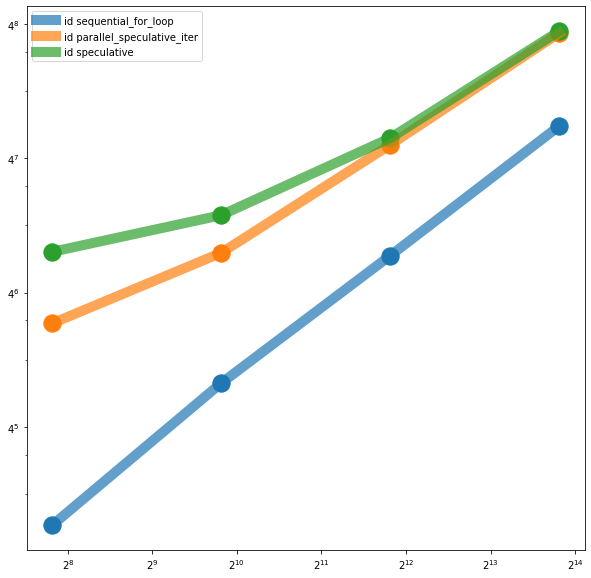

In [23]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-9600$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

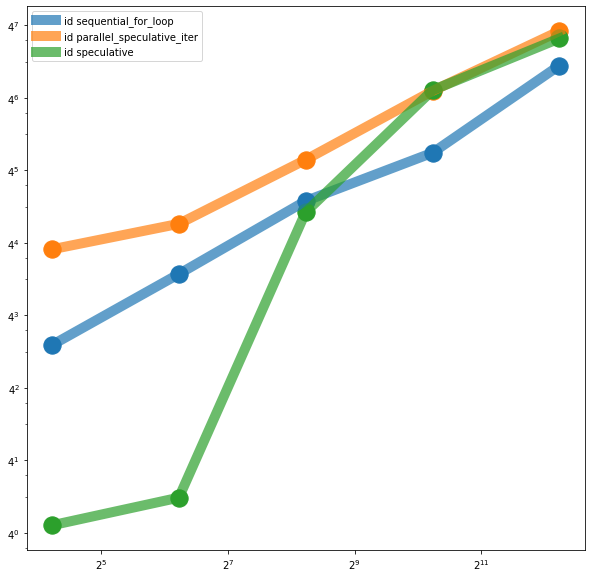

In [24]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-800$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

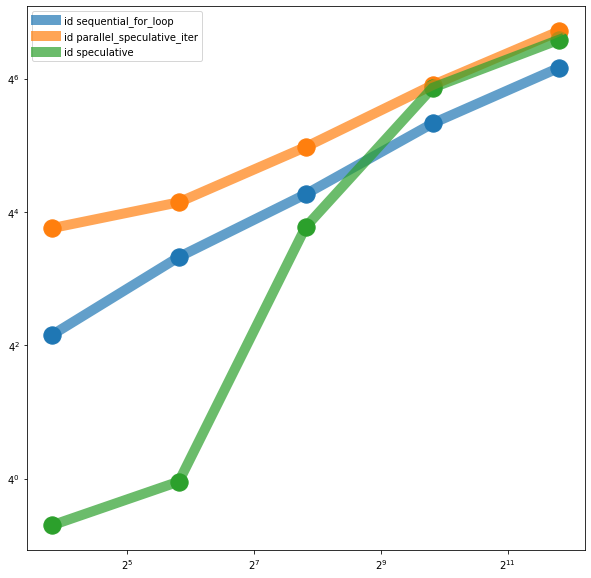

In [25]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-600$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.xscale('log',base=2) 
plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

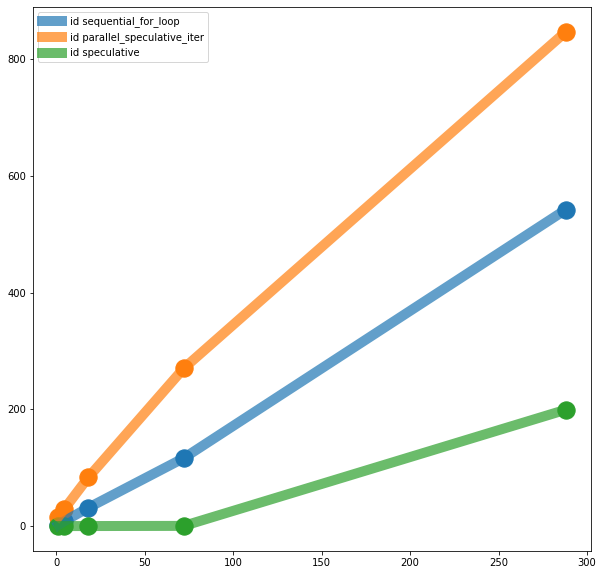

In [26]:
#['512-600', '64-800', '64-96', '512-24', '32-1200', 
# '128-240', '32-4800', '32-12', '128-1200', '256-48', '64-360', '512-48', 
# '32-12000', '128-600', '256-24', '128-48', '128-2400', '128-120', '32-240', 
# '32-120', '128-9600', '64-120', '512-120', '256-2400', '256-4800', '512-96', 
# '64-2400', '256-120', '64-600', '128-96', '32-9600', '32-2400', '256-96', '256-600', 
# '32-24', '128-12', '64-4800', '256-12', '32-48', '32-600', '128-24', '64-24', '64-48', 
# '32-96', '256-240', '64-9600', '64-240', '32-360', '64-12000', '512-12', '256-9600', 
# '64-1200', '64-12', '256-800', '256-360', '128-4800', '512-360', '256-1200', '512-240', 
# '128-800', '512-800', '128-360', '32-800', '128-12000', '256-12000']



b = list(map(lambda value: value[value.value.str.contains(r",*-48$")] ,l))
#print(b)
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.xscale('log',base=2) 
#plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

In [27]:
b = list(map(lambda value: value[value.value.str.contains(r"512-.*$")] ,l))
#print(b)

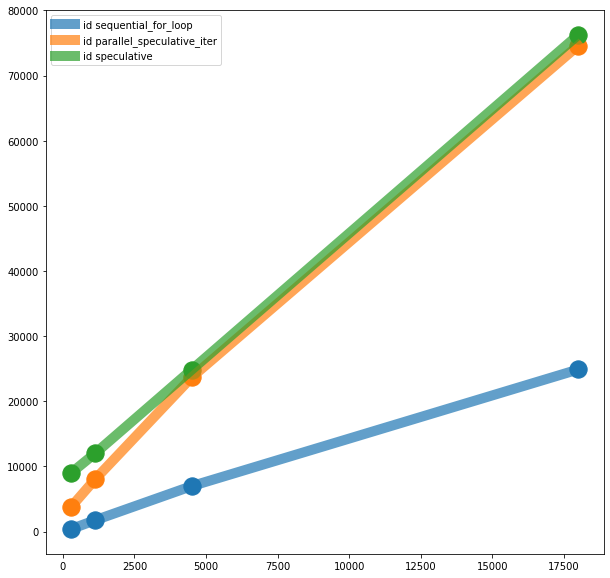

In [28]:
b = list(map(lambda value: value[value.value.str.contains(r",*-12000$")] ,l))
for v  in b :
    plt.scatter(v['size'],v['time'], s=300)
    plt.plot(v['size'],v['time'],label = 'id %s'%v.head().iloc[0]['function'],linewidth=10, alpha=0.7)
    
    
    
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
#plt.xscale('log',base=2) 
#plt.yscale('log',base=4) 

#default_dpi = mpl.rcParamsDefault['figure.dpi']
#mpl.rcParams['figure.dpi'] = default_dpi*2
plt.show()

In [57]:
speculative = b[2]
sequential = b[0]
pairs = list(zip(speculative.items(), sequential.items()))
#print(pairs)
def smaller_time(acc, ab) :
    if ab[0]['time'] < ab[1]['time'] :
        acc.append(ab)
        print(acc)
    return acc

menores = list(reduce(lambda acc,ab: smaller_time(acc,ab) ,[],pairs))

print(menores)

[(('function', 64    speculative
35    speculative
66    speculative
67    speculative
13    speculative
4     speculative
34    speculative
29    speculative
44    speculative
Name: function, dtype: object), ('function', 69    sequential_for_loop
39    sequential_for_loop
71    sequential_for_loop
72    sequential_for_loop
12    sequential_for_loop
4     sequential_for_loop
38    sequential_for_loop
32    sequential_for_loop
49    sequential_for_loop
Name: function, dtype: object)), (('value', 64    512-800
35    512-600
66    512-360
67    512-240
13    512-120
4      512-96
34     512-48
29     512-24
44     512-12
Name: value, dtype: object), ('value', 69    512-800
39    512-600
71    512-360
72    512-240
12    512-120
4      512-96
38     512-48
32     512-24
49     512-12
Name: value, dtype: object)), (('time', 64    12752.983897
35     9192.160527
66     5315.342913
67     3528.775522
13     1826.116756
4      1415.587566
34      199.402474
29        6.803648
44        0.81308